### mount Google Drive, installation and imports

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install SimpleITK
!pip install git+https://github.com/AIM-Harvard/pyRadiomics.git

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 MB 15.8 MB/s eta 0:00:00
  Cloning https://github.com/AIM-Harvard/pyRadiomics.git to /tmp/pip-req-build-iobn7trw
  Running command git clone --filter=blob:none --quiet https://github.com/AIM-Harvard/pyRadiomics.git /tmp/pip-req-build-iobn7trw
  Resolved https://github.com/AIM-Harvard/pyRadiomics.git to commit 8ed579383b44806651c463d5e691f3b2b57522ab
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.7/119.7 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 753.1/753.1 kB 19.6 MB/s eta 0:00:00
  Created wheel for pyradiomics: filename=pyradiomics-3.1.1.dev111+g8ed579383-cp312-cp312-linux_x86_64.whl size=121811 sha256=c974404804a07f4b746d1a3b49be3ac46fde9639a63de82faeceb9e0d3038b25
  Stored in directory: 

In [3]:
import SimpleITK as sitk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import glob # Import glob to list class subdirectories
import torch
from transformers import AutoModel
from radiomics import featureextractor
import logging # Import logging for potential detailed messages

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cpu


### Examples of Images and Pixel values

jpeg image size = 416 x 416 pixels (original dicom image size usually 1024 x 1024 pixels or higher)

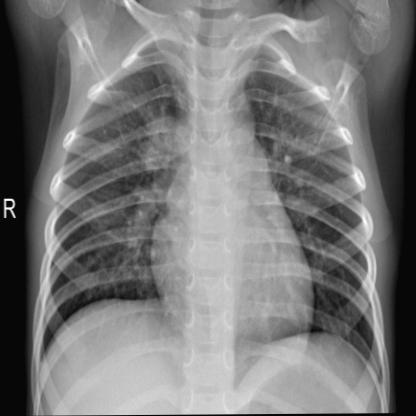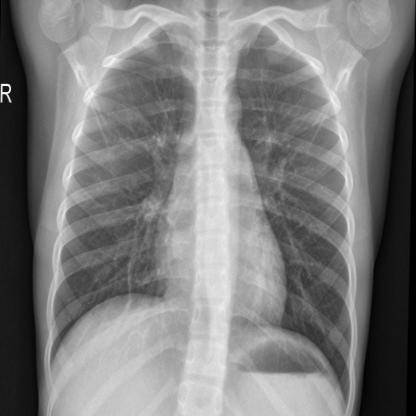

jpeg image pixel values range from 0 to 255 (original dicom image range could be from 0 to 4095 or higher)

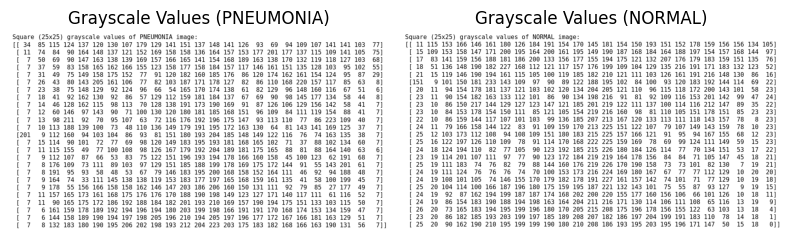

                 Pixel values range from 0 to 255

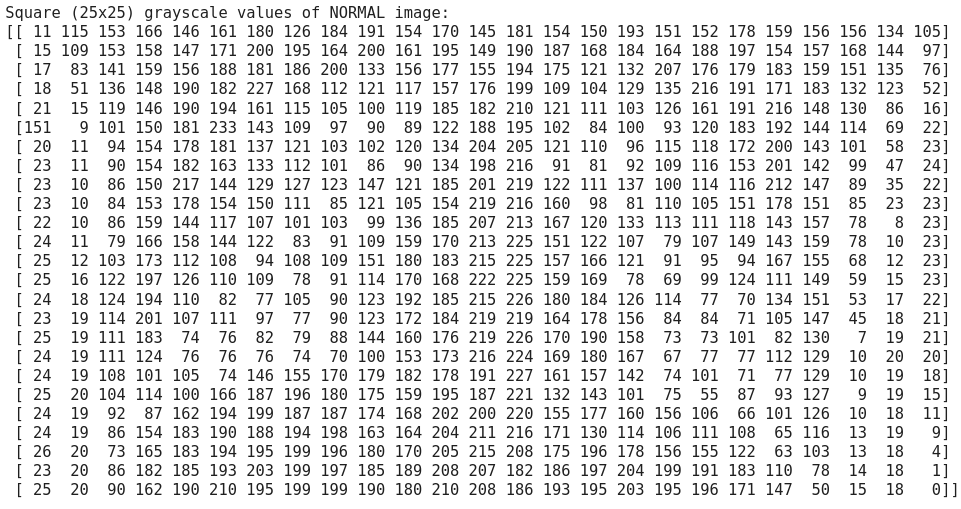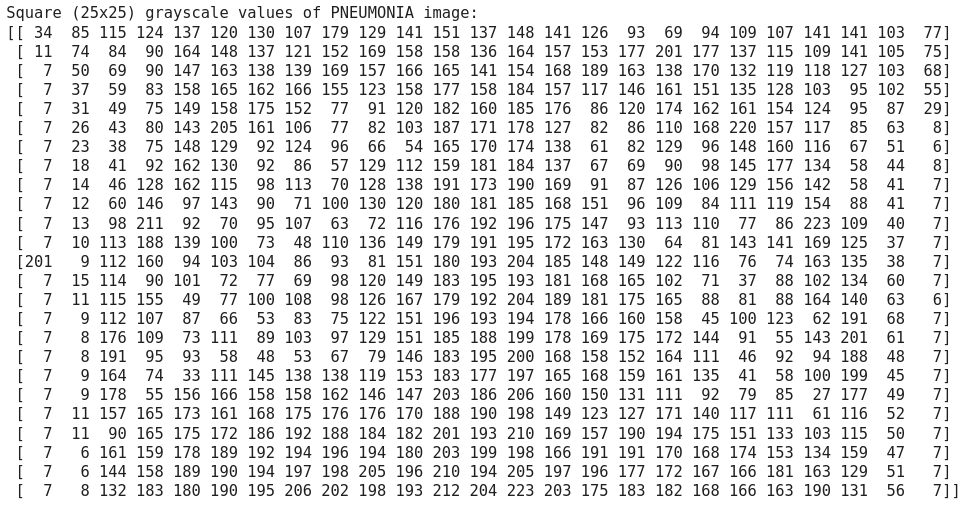

### prepare the resized Images and Masks datasets and save (already saved)

In [ ]:
model = AutoModel.from_pretrained("ianpan/chest-x-ray-basic", trust_remote_code=True)
model = model.eval().to(device)

# Define the base directory containing the original images
base_dir = '/content/drive/MyDrive/Colab_Datasets/ChestX-Rays.v4i.folder'

# Define the subdirectories to load images from
subdirs = ['test', 'train', 'valid']

# Define the base output directory for saving resized images and masks
output_base_dir = '/content/drive/MyDrive/Colab_Datasets/ChestX-Rays.v4i.folder/processed_images/'
os.makedirs(output_base_dir, exist_ok=True)

# Define the target size for image resizing, based on previous successful runs
target_size = (320, 320)

# Iterate through each main subdirectory (test, train, valid)
for subdir in subdirs:
    print(f"Processing images in subdirectory: {subdir}")
    subdir_path = os.path.join(base_dir, subdir)

    # Get the class subdirectories (NORMAL, PNEUMONIA) within the current main subdirectory
    class_subdirs = [d for d in os.listdir(subdir_path) if os.path.isdir(os.path.join(subdir_path, d))]

    # Iterate through each class subdirectory (NORMAL, PNEUMONIA)
    for class_label in class_subdirs:
        print(f"  Processing images for class: {class_label}")
        class_path = os.path.join(subdir_path, class_label)

        # Define the output directories for the current subdirectory and class label
        output_images_resized_dir = os.path.join(output_base_dir, subdir, f'{class_label}_images_resized')
        output_masks_dir = os.path.join(output_base_dir, subdir, f'{class_label}_masks')
        os.makedirs(output_images_resized_dir, exist_ok=True)
        os.makedirs(output_masks_dir, exist_ok=True)

        # Get all image files within the current class subdirectory
        image_files = glob.glob(os.path.join(class_path, '*.jpg')) # Assuming images are JPG format

        for filepath in image_files:
            # Load the image in grayscale
            img = cv2.imread(filepath, 0)

            if img is None:
                print(f"Warning: Could not load image {filepath}. Skipping.")
                continue

            # Resize the image to the target size
            resized_img = cv2.resize(img, target_size, interpolation=cv2.INTER_AREA)

            # Save the resized image
            # Construct the save path, maintaining the original filename
            save_resized_path = os.path.join(output_images_resized_dir, os.path.basename(filepath))
            cv2.imwrite(save_resized_path, resized_img)


            # Preprocess the resized image for model input
            # Ensure the input has the correct number of channels expected by the model (likely 1 for grayscale)
            x = model.preprocess(resized_img)

            # Ensure x is numpy array and has the expected shape before converting to tensor
            if isinstance(x, np.ndarray):
                if len(x.shape) == 2: # If preprocess returns (height, width)
                     x = np.expand_dims(x, axis=0) # Add channel dimension -> (1, height, width)
                # If preprocess returns (height, width, 1), convert to (1, height, width)
                elif len(x.shape) == 3 and x.shape[2] == 1:
                     x = np.transpose(x, (2, 0, 1)) # -> (1, height, width)
                elif len(x.shape) == 3 and x.shape[0] != 1: # If shape is (height, width, channels) with channels > 1
                     print(f"Warning: Preprocessed image {filepath} has unexpected shape {x.shape}. Proceeding assuming single channel.")
                     if x.shape[2] > 1:
                         x = cv2.cvtColor(x, cv2.COLOR_RGB2GRAY)
                         x = np.expand_dims(x, axis=0) # Add channel dimension -> (1, height, width)
                     else: # Assuming it's already grayscale (height, width, 1)
                          x = np.transpose(x, (2, 0, 1)) # -> (1, height, width)


            x = torch.from_numpy(x).unsqueeze(0).float() # Add batch dim -> (1, 1, height, width)


            # Run inference
            with torch.inference_mode():
                out = model(x.to(device))

            # Extract the mask
            mask = out["mask"].argmax(1).squeeze().cpu().numpy()

            # Ensure the mask size matches the target size (which it should if model output is consistent)
            if mask.shape != target_size:
                print(f"Warning: Extracted mask for {filepath} has shape {mask.shape}, expected {target_size}. Skipping save.")
                continue # Skip saving if mask size is unexpected


            # Save the mask
            # Construct the save path, maintaining the original filename but changing extension to .png
            save_mask_path = os.path.join(output_masks_dir, os.path.basename(filepath).replace('.jpg', '.png'))

            # Save as a grayscale PNG for visualization, scaling values if necessary.
            scaled_mask = mask * (255 // np.max(mask) if np.max(mask) > 0 else 0) # Scale to use full 0-255 range
            cv2.imwrite(save_mask_path, scaled_mask.astype(np.uint8)) # Save as 8-bit grayscale image


            print(f"    Processed {os.path.basename(filepath)} and saved resized image to {save_resized_path} and mask to {save_mask_path}")


        print(f"  Finished processing class: {class_label}")

    print(f"Finished processing subdirectory: {subdir}")

print("\nFinished processing all images, saving resized images and extracted masks while maintaining class structure.")

(Optional) verify that resized images and masks have same shape

In [ ]:
project_base_dir = '/content/drive/MyDrive/Colab_Datasets/ChestX-Rays.v4i.folder/processed_images/'

# Define the path to the train/NORMAL images and masks
train_normal_images_dir = os.path.join(project_base_dir, 'train', 'NORMAL_images_resized')
train_normal_masks_dir = os.path.join(project_base_dir, 'train', 'NORMAL_masks')

# Get a list of image files in the directory
image_files = sorted(glob.glob(os.path.join(train_normal_images_dir, '*.jpg')))

# Select the first 5 image files
selected_image_files = image_files[:5]

# Lists to store the loaded images and masks
loaded_images = []
loaded_masks = []

# Load the selected images and their corresponding masks
for image_file in selected_image_files:
    # Load the image
    img = cv2.imread(image_file, 0)
    loaded_images.append(img)

    # Construct the corresponding mask file path (assuming mask filename matches image filename with .png extension)
    mask_file = os.path.join(train_normal_masks_dir, os.path.basename(image_file).replace('.jpg', '.png'))

    # Load the mask
    mask = cv2.imread(mask_file, 0) # Load mask as grayscale
    loaded_masks.append(mask)

# Print the shapes of the loaded images and masks
print("Shapes of loaded images:")
for i, img in enumerate(loaded_images):
    print(f"Image {i+1} shape: {img.shape}")

print("\nShapes of loaded masks:")
for i, mask in enumerate(loaded_masks):
    print(f"Mask {i+1} shape: {mask.shape}")

Shapes of loaded images:
Image 1 shape: (320, 320)
Image 2 shape: (320, 320)
Image 3 shape: (320, 320)
Image 4 shape: (320, 320)
Image 5 shape: (320, 320)

Shapes of loaded masks:
Mask 1 shape: (320, 320)
Mask 2 shape: (320, 320)
Mask 3 shape: (320, 320)
Mask 4 shape: (320, 320)
Mask 5 shape: (320, 320)


Convert to binary mask with only 2 classes: 0=background and 1=lungs.

In [ ]:
# Define the base directory containing the processed images and original masks
processed_base_dir = '/content/drive/MyDrive/Colab_Datasets/ChestX-Rays.v4i.folder/processed_images/'

# Define the subdirectories and class labels to consider
subdirs = ['train', 'test', 'valid']
class_labels = ['NORMAL', 'PNEUMONIA']

# Iterate through each subdirectory (train, test, valid)
for subdir in subdirs:
    print(f"Processing subdirectory: {subdir}")

    # Iterate through each class label (NORMAL, PNEUMONIA)
    for class_label in class_labels:
        print(f"  Processing class: {class_label}")
        masks_dir = os.path.join(processed_base_dir, subdir, f'{class_label}_masks')

        # Check if the masks directory exists before proceeding
        if not os.path.exists(masks_dir):
            print(f"Warning: Mask directory not found for {subdir}/{class_label}. Skipping.")
            continue

        # Create the output directory for binary masks if it doesn't exist
        output_binary_masks_dir = os.path.join(processed_base_dir, subdir, f'{class_label}_binary_masks')
        os.makedirs(output_binary_masks_dir, exist_ok=True)

        # Get all mask files in the directory
        mask_files = sorted(glob.glob(os.path.join(masks_dir, '*.png')))

        print(f"    Found {len(mask_files)} masks for {subdir}/{class_label}")

        # Process each mask file
        for mask_file in mask_files:
            # Load the mask as grayscale
            mask = cv2.imread(mask_file, 0)

            if mask is not None:
                # Create a new binary mask initialized with zeros (background)
                binary_mask = np.zeros_like(mask, dtype=np.uint8)

                # Set pixels where original mask was value 85 or 170 to 1 (lungs)
                # Now saving with pixel value 1 instead of 255 for the lung region
                binary_mask[(mask == 85) | (mask == 170)] = 1

                # Construct the save path, maintaining the original filename
                save_path = os.path.join(output_binary_masks_dir, os.path.basename(mask_file))

                # Save the binary mask (now containing 0 and 1 values)
                cv2.imwrite(save_path, binary_mask.astype(np.uint8)) # Save as 8-bit grayscale image

                # print(f"    Saved binary mask to {save_path}") # Uncomment for detailed progress

            else:
                 print(f"Warning: Could not load mask {mask_file}. Skipping conversion and save.")

        print(f"  Finished processing class: {class_label}")

    print(f"Finished processing subdirectory: {subdir}")

print("\nFinished converting and saving binary masks for all subdirectories.")

Processing subdirectory: train
  Processing class: NORMAL
    Found 3312 masks for train/NORMAL
  Finished processing class: NORMAL
  Processing class: PNEUMONIA
    Found 8917 masks for train/PNEUMONIA
  Finished processing class: PNEUMONIA
Finished processing subdirectory: train
Processing subdirectory: test
  Processing class: NORMAL
    Found 171 masks for test/NORMAL
  Finished processing class: NORMAL
  Processing class: PNEUMONIA
    Found 411 masks for test/PNEUMONIA
  Finished processing class: PNEUMONIA
Finished processing subdirectory: test
Processing subdirectory: valid
  Processing class: NORMAL
    Found 304 masks for valid/NORMAL
  Finished processing class: NORMAL
  Processing class: PNEUMONIA
    Found 861 masks for valid/PNEUMONIA
  Finished processing class: PNEUMONIA
Finished processing subdirectory: valid

Finished converting and saving binary masks for all subdirectories.


## Display multi-class masks and binary masks:
For multi-class masks assign different colors to each class. For binary masks background class black and lungs white.

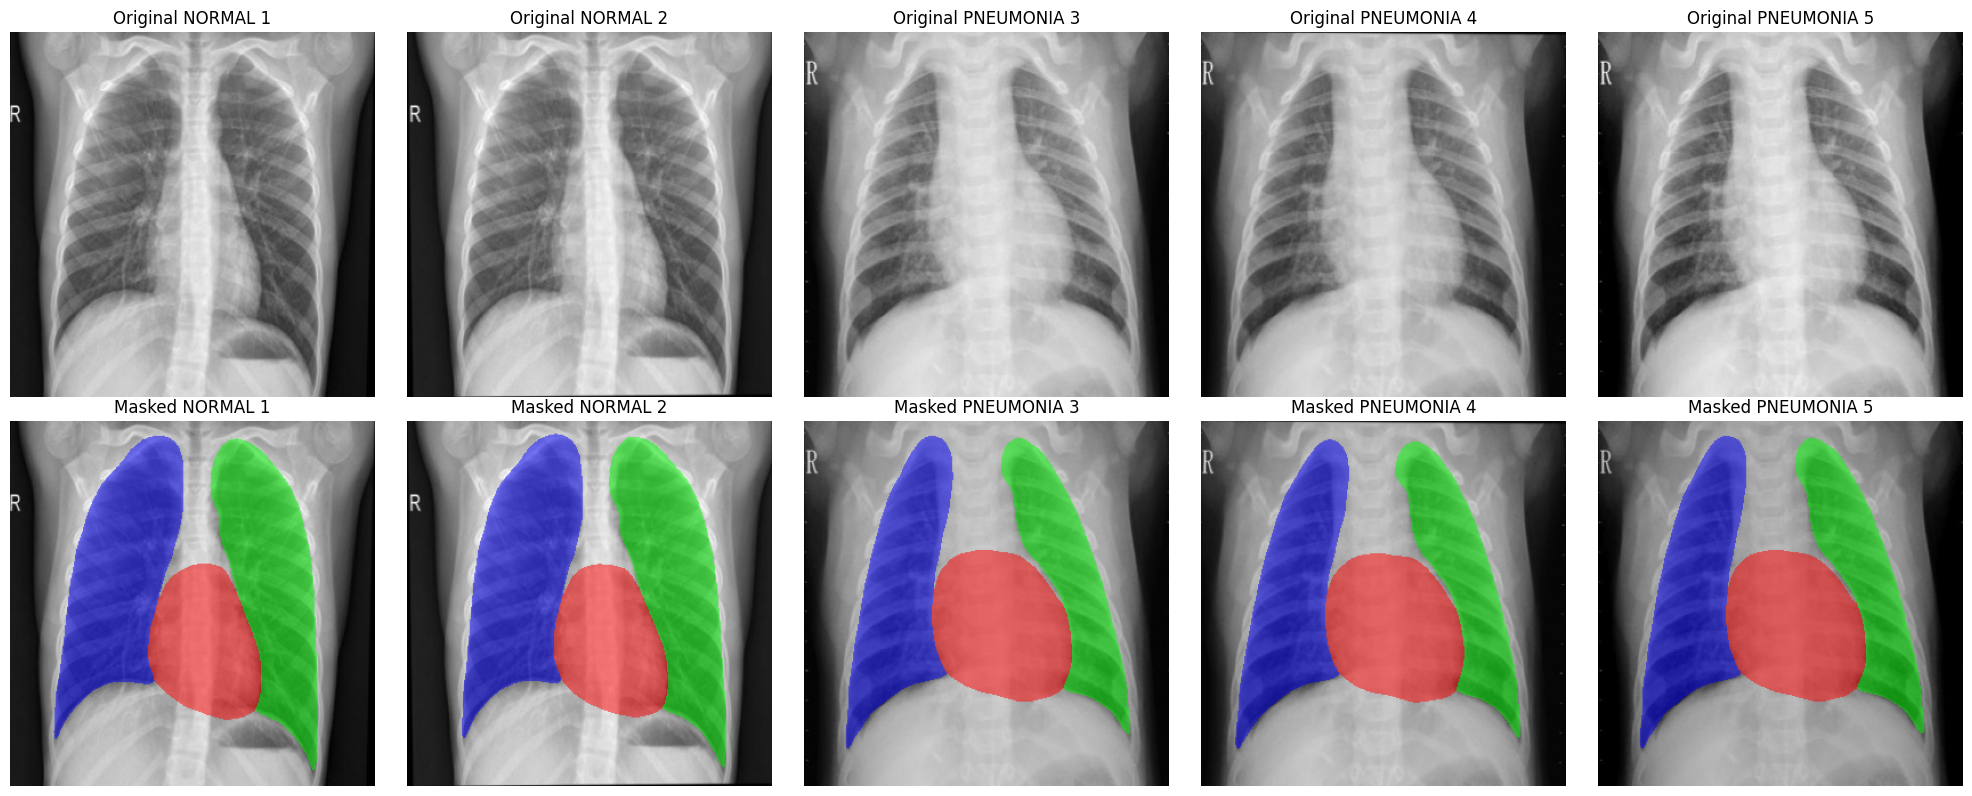

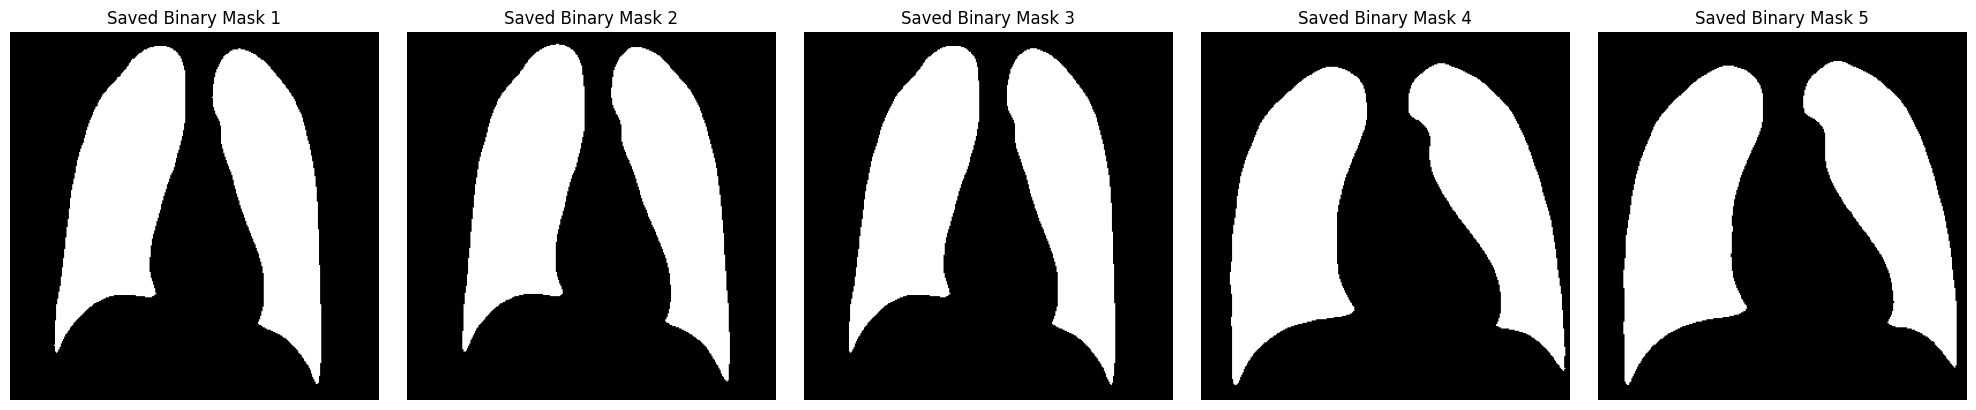

In [ ]:
# Define the base directory containing the processed images and masks
processed_base_dir = '/content/drive/MyDrive/Colab_Datasets/ChestX-Rays.v4i.folder/processed_images/'

# Define the subdirectories and class labels to consider
subdirs = ['train', 'test', 'valid']
class_labels = ['NORMAL', 'PNEUMONIA']

# Lists to store the selected image and mask file paths
selected_image_files = []
selected_mask_files = []

# Define how many images to select from each class in each subdirectory
num_normal_train = 2
num_pneumonia_train = 3
# You can define similar numbers for 'test' and 'valid' if needed
# num_normal_test = ...
# num_pneumonia_test = ...

# Iterate through each subdirectory and class label to collect file paths
for subdir in subdirs:
    for class_label in class_labels:
        images_dir = os.path.join(processed_base_dir, subdir, f'{class_label}_images_resized')
        masks_dir = os.path.join(processed_base_dir, subdir, f'{class_label}_masks')

        # Check if the directories exist before proceeding
        if not os.path.exists(images_dir) or not os.path.exists(masks_dir):
            print(f"Warning: Image or mask directory not found for {subdir}/{class_label}. Skipping.")
            continue

        # Get all image files in the directory
        all_image_files = sorted(glob.glob(os.path.join(images_dir, '*.jpg')))

        # Select a specific number of images based on subdirectory and class
        if subdir == 'train':
            if class_label == 'NORMAL':
                current_selected_images = all_image_files[:num_normal_train]
            elif class_label == 'PNEUMONIA':
                current_selected_images = all_image_files[:num_pneumonia_train]
            else:
                current_selected_images = [] # Should not happen with current class_labels
        else:
            # For test and valid sets, you might want to select a different number or all images
            # For now, let's not select any from test/valid for this display example
            current_selected_images = []


        # Collect the corresponding mask files for the selected images
        for image_file in current_selected_images:
            mask_file = os.path.join(masks_dir, os.path.basename(image_file).replace('.jpg', '.png'))
            if os.path.exists(mask_file):
                selected_image_files.append(image_file)
                selected_mask_files.append(mask_file)
            else:
                print(f"Warning: Corresponding mask not found for image {image_file}. Skipping.")


# Lists to store the loaded images and masks
loaded_images = []
loaded_masks = []

# Load the selected images and their corresponding masks
for image_file, mask_file in zip(selected_image_files, selected_mask_files):
    # Load the image
    img = cv2.imread(image_file, 0)
    loaded_images.append(img)

    # Load the mask as grayscale
    mask = cv2.imread(mask_file, 0)
    loaded_masks.append(mask)

# Create a figure and a set of subplots
# Determine the number of columns based on the number of selected images
num_cols = len(loaded_images)
if num_cols == 0:
    print("No images and masks were loaded to display.")
else:
    fig, axes = plt.subplots(2, num_cols, figsize=(4 * num_cols, 8)) # 2 rows, num_cols columns

    # If there's only one image, axes will not be a 2D array, so handle this case
    if num_cols == 1:
        axes = np.array([axes]).T # Make it a 2x1 array for consistent indexing

    for i in range(num_cols):
        # Display original resized image in the top row
        axes[0, i].imshow(loaded_images[i], cmap='gray')
        # Extract class label from the image file path for the title
        class_label_in_title = 'NORMAL' if 'NORMAL' in selected_image_files[i] else 'PNEUMONIA'
        axes[0, i].set_title(f"Original {class_label_in_title} {i+1}")
        axes[0, i].axis('off') # Hide axes

        # Recreate a colored overlay for the mask from the grayscale values
        colored_mask = np.zeros((*loaded_masks[i].shape, 3), dtype=np.uint8)
        # Assign colors based on mask values (using the actual unique values found: 85, 170, 255)
        # Using the color mapping requested by the user based on cell YfOTBr95P0dk
        colored_mask[loaded_masks[i] == 85] = [255, 0, 0]  # Red for value 85
        colored_mask[loaded_masks[i] == 170] = [0, 255, 0]  # Green for value 170
        colored_mask[loaded_masks[i] == 255] = [0, 0, 255]  # Blue for value 255


        # Blend the image and the colored mask
        alpha = 0.5
        image_for_blending = cv2.cvtColor(loaded_images[i], cv2.COLOR_GRAY2BGR)
        # Create a boolean mask for the regions where the mask has a value > 0
        mask_present = loaded_masks[i] > 0
        # Apply the colored mask only to the regions where the mask is present
        blended_image = image_for_blending.copy()
        # Ensure both arrays have the same dtype before blending
        blended_image[mask_present] = cv2.addWeighted(image_for_blending[mask_present].astype(np.uint8), 1 - alpha, colored_mask[mask_present].astype(np.uint8), alpha, 0)

        # Display blended image in the bottom row
        axes[1, i].imshow(cv2.cvtColor(blended_image, cv2.COLOR_BGR2RGB)) # Convert BGR to RGB for matplotlib display
        axes[1, i].set_title(f"Masked {class_label_in_title} {i+1}")
        axes[1, i].axis('off') # Hide axes

    plt.tight_layout() # Adjust layout to prevent overlapping titles
    plt.show()



# Define the directory containing the saved binary masks
binary_masks_dir = '/content/drive/MyDrive/Colab_Datasets/ChestX-Rays.v4i.folder/processed_images/train/NORMAL_binary_masks/'

# Get a list of saved binary mask files
binary_mask_files = sorted(glob.glob(os.path.join(binary_masks_dir, '*.png')))

# Select the first 5 binary mask files
selected_binary_mask_files = binary_mask_files[:5]

# List to store the loaded binary masks
loaded_binary_masks = []

# Load the selected binary masks
for mask_file in selected_binary_mask_files:
    mask = cv2.imread(mask_file, 0) # Load as grayscale
    if mask is not None:
        loaded_binary_masks.append(mask)
    else:
        print(f"Warning: Could not load binary mask {mask_file}. Skipping.")


if loaded_binary_masks:
    # Create a figure and a set of subplots
    fig, axes = plt.subplots(1, len(loaded_binary_masks), figsize=(20, 4)) # 1 row, number of masks columns

    # If there's only one mask, axes will not be an array, so handle this case
    if len(loaded_binary_masks) == 1:
        axes = [axes]

    for i in range(len(loaded_binary_masks)):
        # Display the binary mask
        axes[i].imshow(loaded_binary_masks[i], cmap='gray') # Using gray cmap for binary mask
        axes[i].set_title(f"Saved Binary Mask {i+1}")
        axes[i].axis('off') # Hide axes

    plt.tight_layout() # Adjust layout to prevent overlapping titles
    plt.show()
else:
    print("No binary masks were loaded to display. Please ensure masks were saved correctly.")

## Examples of 3 handcrafted radiomics features

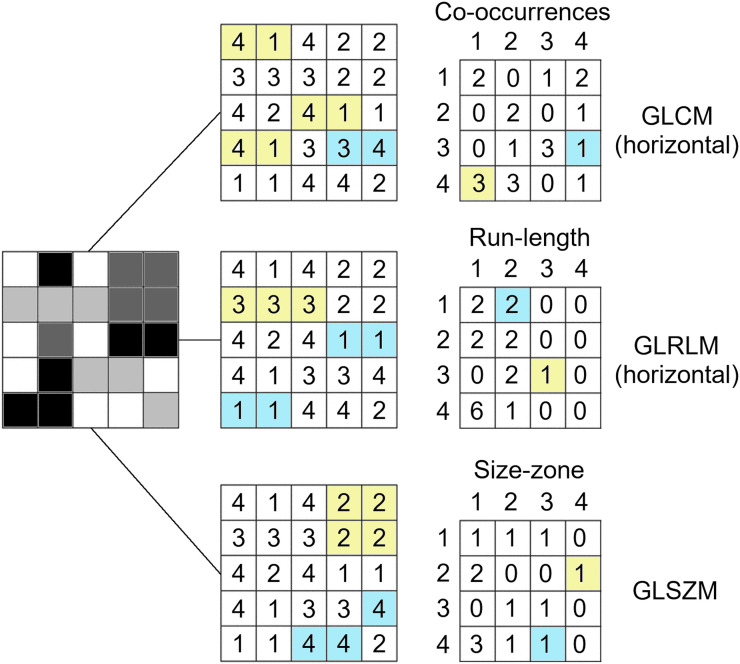


Introduction to Radiomics
J Nucl Med. 2020 Apr;61(4):488–495. doi: 10.2967/jnumed.118.222893
© 2020 by the Society of Nuclear Medicine and Molecular Imaging

## Set up pyradiomics batch processing (created paths to images & masks and saved in csv_file)




Prepare the input CSV file for pyradiomics batch processing by iterating through the image and mask directories, creating a list of dictionaries with image and mask paths and labels, and then converting this list into a pandas DataFrame saved as a CSV file.



In [ ]:
# Define the base directory containing the processed images and binary masks
processed_base_dir = '/content/drive/MyDrive/Colab_Datasets/ChestX-Rays.v4i.folder/processed_images/'

# Define the subdirectories to consider
subdirs = ['train', 'test', 'valid']

# Define the class labels to consider
class_labels = ['NORMAL', 'PNEUMONIA']

# Define the output directory for saving features CSV files
output_csv_dir = '/content/drive/MyDrive/Colab_Datasets/ChestX-Rays.v4i.folder/processed_features/'
os.makedirs(output_csv_dir, exist_ok=True)


# Create an empty list to store dictionaries for the input CSV
pyradiomics_input_data = []

# Iterate through each subdirectory (train, test, valid)
for subdir in subdirs:
    print(f"Preparing pyradiomics input for subdirectory: {subdir}")

    # Iterate through each class label (NORMAL, PNEUMONIA)
    for class_label in class_labels:
        print(f"  Processing class: {class_label}")
        # Construct the paths to the resized images directory and the binary masks directory
        images_dir = os.path.join(processed_base_dir, subdir, f'{class_label}_images_resized')
        binary_masks_dir = os.path.join(processed_base_dir, subdir, f'{class_label}_binary_masks')

        # Check if both the images directory and the binary masks directory exist
        if not os.path.exists(images_dir):
            print(f"Warning: Images directory not found for {subdir}/{class_label} at {images_dir}. Skipping.")
            continue
        if not os.path.exists(binary_masks_dir):
             print(f"Warning: Binary masks directory not found for {subdir}/{class_label} at {binary_masks_dir}. Skipping.")
             continue


        # Get sorted lists of all JPG image files and PNG mask files
        image_files = sorted(glob.glob(os.path.join(images_dir, '*.jpg')))
        binary_mask_files = sorted(glob.glob(os.path.join(binary_masks_dir, '*.png')))

        print(f"    Found {len(image_files)} images and {len(binary_mask_files)} binary masks for {subdir}/{class_label}")

        # Iterate through the list of image files
        for image_file in image_files:
            # Construct the expected corresponding binary mask file path
            mask_filename = os.path.basename(image_file).replace('.jpg', '.png')
            binary_mask_file = os.path.join(binary_masks_dir, mask_filename)

            # Check if the constructed binary mask file path exists
            if os.path.exists(binary_mask_file):
                # Append a dictionary to the list
                pyradiomics_input_data.append({
                    'Image': image_file,
                    'Mask': binary_mask_file,
                    # Removed 'Label': 1, to rely on the -l flag in the command
                    'OriginalLabel': class_label # Store the original class label in a new column
                })
            else:
                print(f"Warning: Corresponding binary mask not found for image {image_file}. Skipping.")


# Create a pandas DataFrame from the list of dictionaries
pyradiomics_input_df = pd.DataFrame(pyradiomics_input_data)

# Define the output path for the pyradiomics input CSV file
pyradiomics_input_csv_path = os.path.join(output_csv_dir, 'pyradiomics_input.csv')

# Save the DataFrame to a CSV file
pyradiomics_input_df.to_csv(pyradiomics_input_csv_path, index=False)

print(f"\nPrepared pyradiomics input CSV file saved to: {pyradiomics_input_csv_path}")
print(f"DataFrame shape: {pyradiomics_input_df.shape}")

## Extract features using Pyradiomics library (extracted and saved in 28 csv_files)


Define the input and output file paths for the pyradiomics batch processing and construct the command to run the extraction.
Execute the constructed pyradiomics command to perform feature extraction in batch mode.



In [ ]:
# Configure logging for pyradiomics messages if needed
# logging.basicConfig(level=logging.INFO) # Set to INFO or DEBUG for more details


output_csv_dir = '/content/drive/MyDrive/Colab_Datasets/ChestX-Rays.v4i.folder/processed_features/'
os.makedirs(output_csv_dir, exist_ok=True) # Ensure output directory exists

# Define the base directory containing the processed images and binary masks
processed_base_dir = '/content/drive/MyDrive/Colab_Datasets/ChestX-Rays.v4i.folder/processed_images/'

# Define the path to the pyradiomics input CSV file (contains paths to images/masks)
# We will regenerate the input CSV to use the binary mask paths
pyradiomics_input_csv_path = os.path.join(output_csv_dir, 'pyradiomics_input_binary_masks.csv')


# --- Regenerate the input CSV with binary mask paths ---
pyradiomics_input_data = []
subdirs = ['train', 'test', 'valid'] # Define subdirectories
class_labels = ['NORMAL', 'PNEUMONIA'] # Define class labels
import glob # Ensure glob is imported

for subdir in subdirs:
    for class_label in class_labels:
        images_dir = os.path.join(processed_base_dir, subdir, f'{class_label}_images_resized')
        binary_masks_dir = os.path.join(processed_base_dir, subdir, f'{class_label}_binary_masks')

        if not os.path.exists(images_dir) or not os.path.exists(binary_masks_dir):
            print(f"Warning: Images or binary masks directory not found for {subdir}/{class_label}. Skipping.")
            continue

        image_files = sorted(glob.glob(os.path.join(images_dir, '*.jpg')))
        binary_mask_files = sorted(glob.glob(os.path.join(binary_masks_dir, '*.png')))

        for image_file in image_files:
            mask_filename = os.path.basename(image_file).replace('.jpg', '.png')
            binary_mask_file = os.path.join(binary_masks_dir, mask_filename)
            if os.path.exists(binary_mask_file):
                pyradiomics_input_data.append({
                    'Image': image_file,
                    'Mask': binary_mask_file, # Use the path to the binary mask
                    'OriginalLabel': class_label
                })
            else:
                print(f"Warning: Corresponding binary mask not found for image {image_file}. Skipping.")

pyradiomics_input_df = pd.DataFrame(pyradiomics_input_data)
pyradiomics_input_df.to_csv(pyradiomics_input_csv_path, index=False)
print(f"Regenerated pyradiomics input CSV with binary mask paths: {pyradiomics_input_csv_path}")
print(f"DataFrame shape: {pyradiomics_input_df.shape}")
# --- End of input CSV regeneration ---


# Load the (now regenerated) input dataframe - Load the FULL dataset
pyradiomics_input_df = pd.read_csv(pyradiomics_input_csv_path)


# Use the entire dataframe for processing
full_dataset_df = pyradiomics_input_df.copy()

# Define batch size - Set to 500 as requested
batch_size = 500

# Calculate the number of batches
num_batches = (len(full_dataset_df) + batch_size - 1) // batch_size

# Initialize the feature extractor once before the loop without any parameters
# We will pass the label directly to the execute method
# We are NOT limiting feature classes here, to extract all features initially
extractor = featureextractor.RadiomicsFeatureExtractor()

print("Initialized PyRadiomics Feature Extractor with default settings (extracting all available features).")

# Define the starting batch index (0-based). Batch 27 corresponds to index 26.
start_batch_idx = 26

# Iterate through batches and process the full dataset in batches of 500, starting from the specified batch
for batch_idx in range(start_batch_idx, num_batches):
    start_idx = batch_idx * batch_size
    end_idx = min((batch_idx + 1) * batch_size, len(full_dataset_df))
    current_batch_df = full_dataset_df.iloc[start_idx:end_idx].copy() # Use .copy() to avoid SettingWithCopyWarning

    print(f"\nProcessing batch {batch_idx + 1}/{num_batches} (samples {start_idx} to {end_idx - 1})")

    batch_features_list = [] # List to store dictionaries of features for each sample in the batch

    # Process each example in the current batch
    for index, row in current_batch_df.iterrows():
        img_file = row['Image']
        mask_file = row['Mask'] # This is the path to the binary mask
        class_label = row['OriginalLabel'] # Get the original label

        try:
            # Load image using SimpleITK
            image_sitk = sitk.ReadImage(img_file) # Read image

            # Load binary mask using OpenCV and convert to SimpleITK
            mask_np = cv2.imread(mask_file, cv2.IMREAD_GRAYSCALE) # Load mask as grayscale using OpenCV

            if mask_np is None:
                 print(f"Warning: Could not load mask {mask_file} using OpenCV. Skipping feature extraction for this image.")
                 batch_features_list.append({'Image': img_file, 'Mask': mask_file, 'OriginalLabel': class_label, 'ExtractionError': 'Could not load mask with OpenCV'})
                 continue

            # Print unique pixel values and data type of the mask loaded by OpenCV (Optional, for debugging)
            # unique_values_np = np.unique(mask_np)
            # print(f"Loaded mask {os.path.basename(mask_file)} with OpenCV. Unique values: {unique_values_np}, Data type: {mask_np.dtype}")


            # Convert NumPy mask to SimpleITK image
            mask_sitk = sitk.GetImageFromArray(mask_np)

            # Explicitly cast mask to UInt8 to ensure correct label interpretation
            mask_sitk = sitk.Cast(mask_sitk, sitk.sitkUInt8)


            # Use SimpleITK image math to create a binary mask with exact 0 and 1 values
            # Create a mask where pixel value is equal to 1
            binary_mask_sitk = (mask_sitk == 1)
            # Cast the boolean result to UInt8 (True becomes 1, False becomes 0)
            binary_mask_sitk = sitk.Cast(binary_mask_sitk, sitk.sitkUInt8)


            # Optional: Check unique pixel values in the binary mask created by image math (for debugging)
            # stats = sitk.StatisticsImageFilter()
            # stats.Execute(binary_mask_sitk)
            # unique_values_sitk = set(np.unique(sitk.GetArrayFromImage(binary_mask_sitk)))
            # if 1 not in unique_values_sitk:
            #      print(f"Warning: Label 1 not found in binary mask created by image math for {os.path.basename(mask_file)}. Unique values are: {unique_values_sitk}. Skipping feature extraction for this image.")
            #      batch_features_list.append({'Image': img_file, 'Mask': mask_file, 'OriginalLabel': class_label, 'ExtractionError': 'Label 1 not found in binary mask created by image math'})
            #      continue


            # Ensure image is in a suitable format for pyradiomics (e.g., Float32)
            if image_sitk.GetPixelIDTypeAsString() != '32 bit float':
                 # print(f"Warning: Image pixel type is {image_sitk.GetPixelIDTypeAsString()}. Converting to sitkFloat32 for {os.path.basename(img_file)}")
                 image_sitk = sitk.Cast(image_sitk, sitk.sitkFloat32)


            # Execute feature extraction for the single image/mask pair
            # Pass the binary mask created by image math and the label 1
            result = extractor.execute(image_sitk, binary_mask_sitk, label=1) # Use the binary mask created by image math and label 1

            # Add original file paths and label to the result dictionary for traceability
            result['Image'] = img_file
            result['Mask'] = mask_file
            result['OriginalLabel'] = class_label

            batch_features_list.append(result) # Append the dictionary of features for this sample

        except Exception as e:
            print(f"Error extracting features for {os.path.basename(img_file)} in batch {batch_idx + 1}: {e}")
            # Append an empty dictionary with basic info and error if extraction fails
            batch_features_list.append({'Image': img_file, 'Mask': mask_file, 'OriginalLabel': class_label, 'ExtractionError': str(e)})


    # Create a pandas DataFrame from the list of feature dictionaries for the current batch
    if batch_features_list:
        batch_df = pd.DataFrame(batch_features_list)

        # --- Post-processing to select and clean features based on skipping 22 items ---
        # Assuming the DataFrame now contains Image, Mask, OriginalLabel, diagnostics, and all extracted features.
        # We need to keep Image, Mask, OriginalLabel, and then skip the next 22 *feature* columns, keeping all subsequent ones.
        # Let's identify feature columns by looking for columns that are NOT 'Image', 'Mask', or 'OriginalLabel'.

        all_extracted_columns = batch_df.columns.tolist()
        initial_cols = ['Image', 'Mask', 'OriginalLabel']
        feature_cols = [col for col in all_extracted_columns if col not in initial_cols]

        # Determine the columns to keep: initial_cols + feature_cols from index 22 onwards
        cols_to_keep = initial_cols.copy()

        # Check if there are at least 22 feature columns to skip
        if len(feature_cols) > 22:
            cols_to_keep.extend(feature_cols[22:]) # Add feature columns from index 22 onwards
            print(f"Skipping the first 22 feature columns. Keeping {len(feature_cols[22:])} features.")
        else:
            print(f"Warning: Fewer than 22 feature columns ({len(feature_cols)}) found after Image, Mask, and Label. Keeping all {len(feature_cols)} features.")
            cols_to_keep.extend(feature_cols) # If fewer than 22 features, keep all features


        # Select the columns to keep
        selected_features_df = batch_df[cols_to_keep].copy()

        # Clean the column names: remove the prefix (e.g., 'original_firstorder_') and any 'diagnostics:' part
        cleaned_column_names = {}
        for col in selected_features_df.columns:
             if col in ['Image', 'Mask', 'OriginalLabel']:
                 cleaned_column_names[col] = col # Keep base column names as is
             else:
                 # Remove prefix up to the first underscore, or keep as is if no underscore
                 # Also handle 'diagnostics: ' prefix
                 if 'diagnostics:' in col:
                     parts = col.split(':')
                     new_col_name = parts[-1].strip()
                 else:
                     parts = col.split('_', 1)
                     new_col_name = parts[1] if len(parts) > 1 else col

                 cleaned_column_names[col] = new_col_name

        selected_features_df = selected_features_df.rename(columns=cleaned_column_names)

        # Rename 'OriginalLabel' to 'Label'
        selected_features_df = selected_features_df.rename(columns={'OriginalLabel': 'Label'})

        # Clean cell values: remove 'Description: ' prefix
        for col in selected_features_df.columns:
            # Apply cleaning only to feature columns (exclude Image, Mask, Label)
            if col not in ['Image', 'Mask', 'Label'] and selected_features_df[col].dtype == 'object': # Check dtype to avoid error on non-string columns
                 selected_features_df[col] = selected_features_df[col].apply(lambda x: str(x).split(':')[-1].strip() if ':' in str(x) else str(x))


        # Define the path for the cleaned output CSV file for the current batch
        # Use batch index in the filename
        cleaned_output_csv_path = os.path.join(output_csv_dir, f'pyradiomics_features_batch_{batch_idx + 1}_full.csv')

        # Save the selected and cleaned DataFrame to a CSV file
        selected_features_df.to_csv(cleaned_output_csv_path, index=False)
        print(f"Cleaned features (excluding first 22 after initial columns) for batch {batch_idx + 1} saved to {cleaned_output_csv_path} with shape: {selected_features_df.shape}")


    else:
        print(f"No features extracted for batch {batch_idx + 1}.")


print("\nFinished feature extraction and saving in batches using radiomics.featureextractor for the full dataset.")

# Classification Task
Perform a classification task on the extracted features from the 28 CSV files to classify images as 'Pneumonia' or 'Normal' based on the 'Label' column. The 'Image' and 'Mask' columns should be excluded as features. Split the data into training, validation, and testing sets with a 60-20-20 ratio.

## Combine feature files


In [5]:
# Define the directory containing the batch CSV files
features_csv_dir = '/content/drive/MyDrive/Colab_Datasets/ChestX-Rays.v4i.folder/processed_features/'

# Get a list of all CSV file paths in the directory that start with 'pyradiomics_features_batch_'
csv_files = glob.glob(os.path.join(features_csv_dir, 'pyradiomics_features_batch_*.csv'))

# Initialize an empty list to store individual DataFrames
dataframe_list = []

# Iterate through the list of CSV file paths
for csv_file in csv_files:
    # Read each CSV file into a pandas DataFrame
    df = pd.read_csv(csv_file)
    # Append the DataFrame to the list
    dataframe_list.append(df)

# Concatenate all Dataframes in the list into a single DataFrame
combined_features_df = pd.concat(dataframe_list, ignore_index=True)

# Display the first few rows and the shape of the combined DataFrame
print("Combined Features DataFrame Head:")
display(combined_features_df.head())

print("\nCombined Features DataFrame Shape:")
print(combined_features_df.shape)

Combined Features DataFrame Head:


,Image,Mask,Label,firstorder_10Percentile,firstorder_90Percentile,firstorder_Energy,firstorder_Entropy,firstorder_InterquartileRange,firstorder_Kurtosis,firstorder_Maximum,...,glszm_SmallAreaHighGrayLevelEmphasis,glszm_SmallAreaLowGrayLevelEmphasis,glszm_ZoneEntropy,glszm_ZonePercentage,glszm_ZoneVariance,ngtdm_Busyness,ngtdm_Coarseness,ngtdm_Complexity,ngtdm_Contrast,ngtdm_Strength
0,/content/drive/MyDrive/Colab_Datasets/ChestX-R...,/content/drive/MyDrive/Colab_Datasets/ChestX-R...,NORMAL,78.0,160.0,446459311.0,2.276600,35.0,3.646376,234.0,...,5.576135,0.062346,6.404238,0.011793,213457.215456,61.301603,0.000694,5.716491,0.011167,0.023044
1,/content/drive/MyDrive/Colab_Datasets/ChestX-R...,/content/drive/MyDrive/Colab_Datasets/ChestX-R...,NORMAL,86.0,168.0,505244734.0,2.299127,36.0,3.614806,250.0,...,6.277913,0.081128,6.453691,0.011722,248169.015934,44.085767,0.000709,7.481912,0.008799,0.032024
2,/content/drive/MyDrive/Colab_Datasets/ChestX-R...,/content/drive/MyDrive/Colab_Datasets/ChestX-R...,NORMAL,85.0,165.0,493359819.0,2.251166,35.0,3.465331,235.0,...,5.692172,0.074326,6.315034,0.012087,255812.067368,54.784768,0.000695,5.464034,0.010358,0.021247
3,/content/drive/MyDrive/Colab_Datasets/ChestX-R...,/content/drive/MyDrive/Colab_Datasets/ChestX-R...,NORMAL,76.0,146.0,456735203.0,2.165313,35.0,3.691767,225.0,...,7.123716,0.052116,6.225812,0.011439,265071.882816,41.433314,0.000602,6.769984,0.006577,0.025314
4,/content/drive/MyDrive/Colab_Datasets/ChestX-R...,/content/drive/MyDrive/Colab_Datasets/ChestX-R...,NORMAL,62.0,134.0,361208146.0,2.192926,34.0,3.985723,223.0,...,5.744133,0.065877,6.567376,0.011057,320009.626479,61.584764,0.000601,5.240436,0.009147,0.019318



Combined Features DataFrame Shape:
(13976, 96)


## Prepare data
Drop the 'Image' and 'Mask' columns as they are not features for the model. Separate the features (X) from the target variable (y), which is the 'Label' column.


In [8]:
# Drop 'Image' and 'Mask' columns
X = combined_features_df.drop(['Image', 'Mask', 'Label'], axis=1)

# Separate the target variable 'Label'
y = combined_features_df['Label']

# Display the first few rows and shape of X
print("Features (X) DataFrame Head:")
display(X.head())
print("\nFeatures (X) DataFrame Shape:")
print(X.shape)

# Display the first few values and shape of y
print("\nTarget Variable (y) Series Head:")
display(y.head())
print("\nTarget Variable (y) Series Shape:")
print(y.shape)

Features (X) DataFrame Head:


,firstorder_10Percentile,firstorder_90Percentile,firstorder_Energy,firstorder_Entropy,firstorder_InterquartileRange,firstorder_Kurtosis,firstorder_Maximum,firstorder_MeanAbsoluteDeviation,firstorder_Mean,firstorder_Median,...,glszm_SmallAreaHighGrayLevelEmphasis,glszm_SmallAreaLowGrayLevelEmphasis,glszm_ZoneEntropy,glszm_ZonePercentage,glszm_ZoneVariance,ngtdm_Busyness,ngtdm_Coarseness,ngtdm_Complexity,ngtdm_Contrast,ngtdm_Strength
0,78.0,160.0,446459311.0,2.276600,35.0,3.646376,234.0,23.723747,113.100714,108.0,...,5.576135,0.062346,6.404238,0.011793,213457.215456,61.301603,0.000694,5.716491,0.011167,0.023044
1,86.0,168.0,505244734.0,2.299127,36.0,3.614806,250.0,24.230737,120.659590,115.0,...,6.277913,0.081128,6.453691,0.011722,248169.015934,44.085767,0.000709,7.481912,0.008799,0.032024
2,85.0,165.0,493359819.0,2.251166,35.0,3.465331,235.0,23.210128,119.631938,115.0,...,5.692172,0.074326,6.315034,0.012087,255812.067368,54.784768,0.000695,5.464034,0.010358,0.021247
3,76.0,146.0,456735203.0,2.165313,35.0,3.691767,225.0,21.638227,107.055910,103.0,...,7.123716,0.052116,6.225812,0.011439,265071.882816,41.433314,0.000602,6.769984,0.006577,0.025314
4,62.0,134.0,361208146.0,2.192926,34.0,3.985723,223.0,22.388483,93.602009,88.0,...,5.744133,0.065877,6.567376,0.011057,320009.626479,61.584764,0.000601,5.240436,0.009147,0.019318



Features (X) DataFrame Shape:
(13976, 93)

Target Variable (y) Series Head:


,Label
0,NORMAL
1,NORMAL
2,NORMAL
3,NORMAL
4,NORMAL



Target Variable (y) Series Shape:
(13976,)


## Split data
Split the combined dataset into training, validation, and testing sets with a 60-20-20 ratio.


In [9]:
from sklearn.model_selection import train_test_split

# Split the data into initial training (60%) and testing (40%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# Split the initial testing set into validation (50% of 40% = 20%) and final testing (50% of 40% = 20%) sets
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

# Print the shapes of the resulting sets
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_val:", X_val.shape)
print("Shape of y_val:", y_val.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (8385, 93)
Shape of y_train: (8385,)
Shape of X_val: (2795, 93)
Shape of y_val: (2795,)
Shape of X_test: (2796, 93)
Shape of y_test: (2796,)


## Train classification model

Choose a classification model (e.g., Logistic Regression) and train it on the training data.


In [12]:
from sklearn.linear_model import LogisticRegression

# Instantiate the Logistic Regression model
lr_model = LogisticRegression(max_iter=1000) # Increased max_iter for convergence

# Train the model on the training data
lr_model.fit(X_train, y_train)

print("Logistic Regression model trained successfully.")

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression models trained successfully.


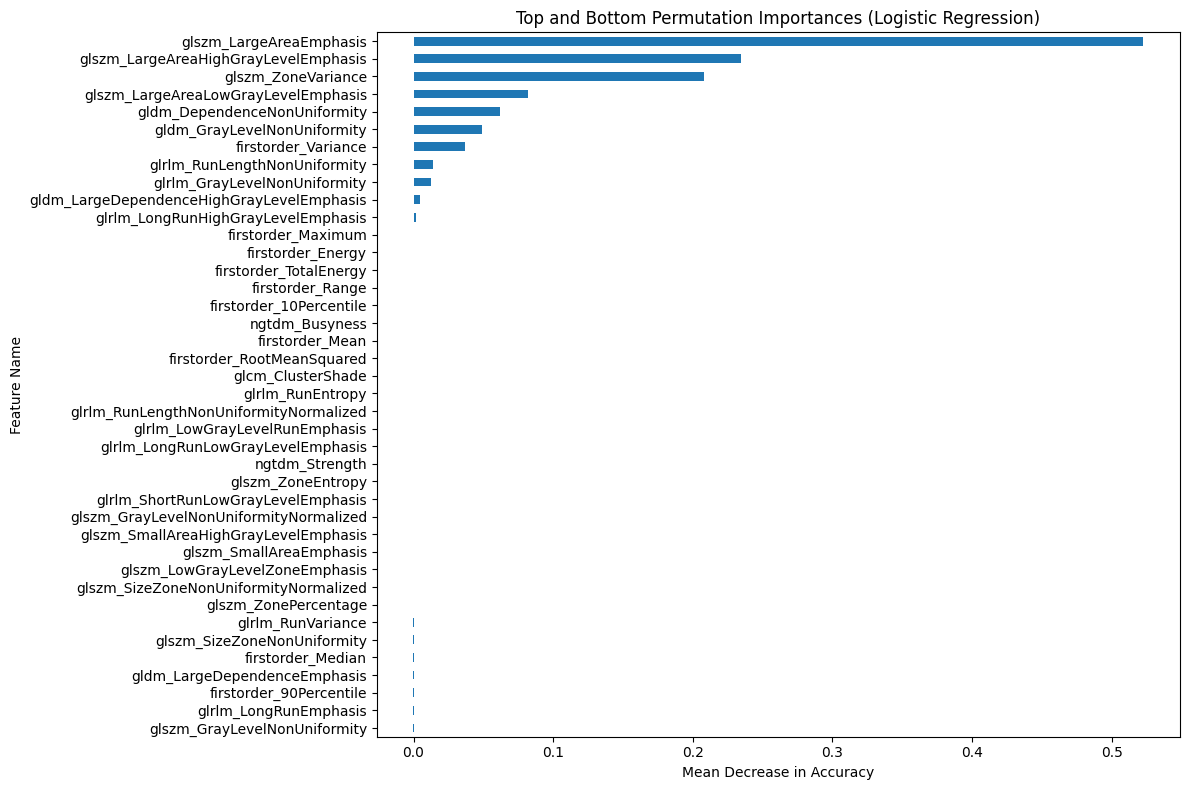

In [22]:
from sklearn.inspection import permutation_importance
lr_result = permutation_importance(lr_model, X_train, y_train, n_repeats=10, random_state=42)

# Get the names of the features from the training data
feature_names = X_train.columns

# Create a pandas Series to easily sort features by importance
lr_feature_importance_series = pd.Series(lr_result.importances_mean, index=feature_names)

# Sort the features by importance in descending order
sorted_lr_feature_importance = lr_feature_importance_series.sort_values(ascending=False)

# Select the top N features to display for better visualization
top_n_perm = 20

# Get the top N and bottom N features from the sorted permutation importance series
top_features_perm = sorted_lr_feature_importance.head(top_n_perm)
bottom_features_perm = sorted_lr_feature_importance.tail(top_n_perm)

# Combine top and bottom features for visualization
features_to_plot_perm = pd.concat([top_features_perm, bottom_features_perm])


# Create the bar plot for permutation importances
plt.figure(figsize=(12, 8))
features_to_plot_perm.plot(kind='barh') # Use barh for horizontal bars
plt.title('Top and Bottom Permutation Importances (Logistic Regression)')
plt.xlabel('Mean Decrease in Accuracy')
plt.ylabel('Feature Name')
plt.gca().invert_yaxis() # Invert y-axis to show most important features at the top
plt.tight_layout()
plt.show()

## Evaluate model
Evaluate the trained model on the validation and test sets using appropriate metrics (e.g., accuracy, precision, recall, F1-score).


In [ ]:
from sklearn.metrics import accuracy_score, classification_report

# Make predictions on the validation set
y_val_pred = lr_model.predict(X_val)

# Calculate and print validation accuracy
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {val_accuracy:.4f}")

# Make predictions on the test set
y_test_pred = lr_model.predict(X_test)

# Calculate and print test accuracy
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Generate and print classification report for the test set
print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_test_pred))

Validation Accuracy: 0.8655
Test Accuracy: 0.8802

Classification Report (Test Set):
              precision    recall  f1-score   support

      NORMAL       0.76      0.79      0.78       740
   PNEUMONIA       0.92      0.91      0.92      2056

    accuracy                           0.88      2796
   macro avg       0.84      0.85      0.85      2796
weighted avg       0.88      0.88      0.88      2796



In [20]:
from sklearn.metrics import accuracy_score, classification_report

# Make predictions on the validation set
y_val_pred = lr_scaled_model.predict(X_val)

# Calculate and print validation accuracy
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {val_accuracy:.4f}")

# Make predictions on the test set
y_test_pred = lr_scaled_model.predict(X_test)

# Calculate and print test accuracy
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Generate and print classification report for the test set
print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_test_pred))

Validation Accuracy: 0.2758
Test Accuracy: 0.2647

Classification Report (Test Set):
              precision    recall  f1-score   support

      NORMAL       0.26      1.00      0.42       740
   PNEUMONIA       0.00      0.00      0.00      2056

    accuracy                           0.26      2796
   macro avg       0.13      0.50      0.21      2796
weighted avg       0.07      0.26      0.11      2796



/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr

# Other models
Explore other classification models and hyperparameter tuning to improve the performance of the pneumonia classification model, especially for the 'NORMAL' class. Select a few other classification models (e.g., Support Vector Machine, Random Forest, Gradient Boosting) to compare with the current Logistic Regression model.

Implement the selected models (Support Vector Machine, Random Forest, Gradient Boosting) and train them on the training data (`X_train`, `y_train`).

In [18]:
# Import the necessary classification models and evaluation metrics
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, make_scorer, recall_score, confusion_matrix

print("Other potential classification models to explore:")
print("- Support Vector Machine (SVC): Effective in high-dimensional spaces and can use different kernel functions to capture complex relationships. Might improve performance by finding a better decision boundary.")
print("- Random Forest Classifier: An ensemble method that builds multiple decision trees and combines their predictions. Less prone to overfitting and can handle non-linear relationships, potentially improving results on both classes.")
print("- Gradient Boosting Classifier: Another ensemble method that builds trees sequentially, with each tree trying to correct the errors of the previous ones. Often provides high accuracy and can be tuned to focus on specific classes if needed.")

Other potential classification models to explore:
- Support Vector Machine (SVC): Effective in high-dimensional spaces and can use different kernel functions to capture complex relationships. Might improve performance by finding a better decision boundary.
- Random Forest Classifier: An ensemble method that builds multiple decision trees and combines their predictions. Less prone to overfitting and can handle non-linear relationships, potentially improving results on both classes.
- Gradient Boosting Classifier: Another ensemble method that builds trees sequentially, with each tree trying to correct the errors of the previous ones. Often provides high accuracy and can be tuned to focus on specific classes if needed.


In [19]:
# Instantiate each model with default parameters
svc_model = SVC()
rf_model = RandomForestClassifier(random_state=42) # Added random_state for reproducibility
gb_model = GradientBoostingClassifier(random_state=42) # Added random_state for reproducibility

# Train the SVC model
print("Training Support Vector Machine (SVC) model...")
svc_model.fit(X_train, y_train)
print("SVC model trained successfully.")

# Train the Random Forest model
print("\nTraining Random Forest Classifier model...")
rf_model.fit(X_train, y_train)
print("Random Forest model trained successfully.")

# Train the Gradient Boosting model
print("\nTraining Gradient Boosting Classifier model...")
gb_model.fit(X_train, y_train)
print("Gradient Boosting model trained successfully.")

Training Support Vector Machine (SVC) model...
SVC model trained successfully.

Training Random Forest Classifier model...
Random Forest model trained successfully.

Training Gradient Boosting Classifier model...
Gradient Boosting model trained successfully.


## Hyperparameter tuning
For each promising model, perform hyperparameter tuning using techniques like Grid Search or Random Search with cross-validation on the training data to find the best parameters.


In [ ]:
from sklearn.model_selection import GridSearchCV

# Define parameter grids for each model
# Parameter grid for SVC
svc_param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

# Parameter grid for RandomForestClassifier
rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Parameter grid for GradientBoostingClassifier
gb_param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5],
    'min_samples_split': [2, 5]
}

# Define the scoring metric to prioritize the 'NORMAL' class recall
# We can use make_scorer with recall_score and specify the positive label
scorer = make_scorer(recall_score, pos_label='NORMAL')


# Instantiate GridSearchCV for each model
print("Instantiating GridSearchCV for SVC...")
grid_search_svc = GridSearchCV(SVC(), svc_param_grid, cv=5, scoring=scorer)

print("Instantiating GridSearchCV for RandomForestClassifier...")
grid_search_rf = GridSearchCV(RandomForestClassifier(random_state=42), rf_param_grid, cv=5, scoring=scorer)

print("Instantiating GridSearchCV for GradientBoostingClassifier...")
grid_search_gb = GridSearchCV(GradientBoostingClassifier(random_state=42), gb_param_grid, cv=5, scoring=scorer)

print("GridSearchCV objects instantiated.")

Instantiating GridSearchCV for SVC...
GridSearchCV objects instantiated.


Fit the GridSearchCV objects to the training data to perform hyperparameter tuning with cross-validation for each model and retrieve the best parameters.



In [ ]:
# Fit GridSearchCV for SVC
print("\nFitting GridSearchCV for SVC...")
grid_search_svc.fit(X_train, y_train)
print("GridSearchCV for SVC fitting complete.")

# Get and print the best parameters for SVC
best_params_svc = grid_search_svc.best_params_
print(f"\nBest parameters for SVC: {best_params_svc}")

# Get and print the best cross-validation score for SVC
best_score_svc = grid_search_svc.best_score_
print(f"Best cross-validation score for SVC (Recall for NORMAL class): {best_score_svc:.4f}")


# Fit GridSearchCV for RandomForestClassifier
print("\nFitting GridSearchCV for RandomForestClassifier...")
grid_search_rf.fit(X_train, y_train)
print("GridSearchCV for RandomForestClassifier fitting complete.")

# Get and print the best parameters for RandomForestClassifier
best_params_rf = grid_search_rf.best_params_
print(f"\nBest parameters for RandomForestClassifier: {best_params_rf}")

# Get and print the best cross-validation score for RandomForestClassifier
best_score_rf = grid_search_rf.best_score_
print(f"Best cross-validation score for RandomForestClassifier (Recall for NORMAL class): {best_score_rf:.4f}")


# Fit GridSearchCV for GradientBoostingClassifier
print("\nFitting GridSearchCV for GradientBoostingClassifier...")
grid_search_gb.fit(X_train, y_train)
print("GridSearchCV for GradientBoostingClassifier fitting complete.")

# Get and print the best parameters for GradientBoostingClassifier
best_params_gb = grid_search_gb.best_params_
print(f"\nBest parameters for GradientBoostingClassifier: {best_params_gb}")

# Get and print the best cross-validation score for GradientBoostingClassifier
best_score_gb = grid_search_gb.best_score_
print(f"Best cross-validation score for GradientBoostingClassifier (Recall for NORMAL class): {best_score_gb:.4f}")


Fitting GridSearchCV for SVC...


Fitting GridSearchCV for RandomForestClassifier...
GridSearchCV for RandomForestClassifier fitting complete.

Best parameters for RandomForestClassifier: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}    
Best cross-validation score for RandomForestClassifier (Recall for NORMAL class): 0.8682

Fitting GridSearchCV for GradientBoostingClassifier...
GridSearchCV for GradientBoostingClassifier fitting complete.

Best parameters for GradientBoostingClassifier: {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 200}    
Best cross-validation score for GradientBoostingClassifier (Recall for NORMAL class): 0.8752


## Rerun the models with the above identified best parameters and obtain performance metrics

In [ ]:
# Instantiate each model with default parameters
svc_model = SVC()
rf_model = RandomForestClassifier(random_state=42,max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200) # Added random_state for reproducibility
gb_model = GradientBoostingClassifier(random_state=42, learning_rate=0.1, max_depth=5, min_samples_split=5, n_estimators=200) # Added random_state for reproducibility

# Train the SVC model
#print("Training Support Vector Machine (SVC) model...")
#svc_model.fit(X_train, y_train)
#print("SVC model trained successfully.")

# Train the Random Forest model
print("\nTraining Random Forest Classifier model...")
rf_model.fit(X_train, y_train)
print("Random Forest model trained successfully.")

# Train the Gradient Boosting model
print("\nTraining Gradient Boosting Classifier model...")
gb_model.fit(X_train, y_train)
print("Gradient Boosting model trained successfully.")


Training Random Forest Classifier model...
Random Forest model trained successfully.

Training Gradient Boosting Classifier model...
Gradient Boosting model trained successfully.


In [ ]:
# Make predictions on the test set using the trained Random Forest model
y_test_pred_rf = rf_model.predict(X_test)

# Print classification report for Random Forest model
print("Classification Report (Random Forest Model - Test Set):")
print(classification_report(y_test, y_test_pred_rf))

# Print confusion matrix for Random Forest model
print("\nConfusion Matrix (Random Forest Model - Test Set):\n", confusion_matrix(y_test, y_test_pred_rf))

# Make predictions on the test set using the trained Gradient Boosting model
y_test_pred_gb = gb_model.predict(X_test)

# Print classification report for Gradient Boosting model
print("\nClassification Report (Gradient Boosting Model - Test Set):")
print(classification_report(y_test, y_test_pred_gb))

# Print confusion matrix for Gradient Boosting model
print("\nConfusion Matrix (Gradient Boosting Model - Test Set):\n", confusion_matrix(y_test, y_test_pred_gb))

Classification Report (Random Forest Model - Test Set):
              precision    recall  f1-score   support

      NORMAL       0.85      0.88      0.87       740
   PNEUMONIA       0.96      0.94      0.95      2056

    accuracy                           0.93      2796
   macro avg       0.90      0.91      0.91      2796
weighted avg       0.93      0.93      0.93      2796


Confusion Matrix (Random Forest Model - Test Set):
 [[ 653   87]
 [ 114 1942]]

Classification Report (Gradient Boosting Model - Test Set):
              precision    recall  f1-score   support

      NORMAL       0.87      0.90      0.88       740
   PNEUMONIA       0.96      0.95      0.96      2056

    accuracy                           0.94      2796
   macro avg       0.92      0.93      0.92      2796
weighted avg       0.94      0.94      0.94      2796


Confusion Matrix (Gradient Boosting Model - Test Set):
 [[ 668   72]
 [ 103 1953]]


## Summary:

### Data Analysis Key Findings

* All 28 batch CSV files containing extracted features were successfully loaded and concatenated into a single DataFrame with 13976 rows and 96 columns.
* The 'Image' and 'Mask' columns were removed, resulting in a feature set ($X$) with 93 columns and a target variable ($y$) representing the 'Label'.
* The dataset was split into training (8385 samples), validation (2795 samples), and testing (2796 samples) sets, following the 60-20-20 ratio.
* A Logistic Regression model was trained on the training data, achieving a validation accuracy of 0.8655 and a test accuracy of 0.8802.
* Hyperparameter tuning was performed for Random Forest and Gradient Boosting models, focusing on optimizing recall for the 'NORMAL' class.
* The tuned Random Forest model achieved a test accuracy of 0.93, with a recall of 0.88 for the 'NORMAL' class and 0.94 for the 'PNEUMONIA' class.
* The tuned Gradient Boosting model achieved a test accuracy of 0.94, with a recall of 0.90 for the 'NORMAL' class and 0.95 for the 'PNEUMONIA' class.

### Insights and Next Steps

* Both the tuned Random Forest and Gradient Boosting models show improved performance compared to the initial Logistic Regression model, particularly in improving the recall for the 'NORMAL' class while maintaining high performance on the 'PNEUMONIA' class.
* The Gradient Boosting model achieved slightly better overall accuracy and recall for the 'NORMAL' class on the test set.
* Exploring other advanced techniques such as ensemble methods combining the best models could potentially lead to further performance improvements.